In [1]:
#| default_exp datasets

In [2]:
import sys; sys.path.append('/notebooks')

In [1]:
#|export
from __future__ import annotations
import math
import logging, pickle, gzip, os, time, shutil, torch
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
from operator import itemgetter
from itertools import zip_longest
import fastcore.all as fc
from torch.utils.data import default_collate
from miniai.training import * 

from torch import tensor, nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from datasets import load_dataset, load_dataset_builder

import torchvision.transforms.functional as TF
from fastcore.test import test_close

In [4]:
torch.set_printoptions(precision=2, linewidth=140, sci_mode=False)
torch.manual_seed(1)
plt.style.use('fast')
logging.disable(logging.WARNING)

# Huggingface Datasets 🤗

In [5]:
name = "fashion_mnist"
ds_builder = load_dataset_builder(name)

In [6]:
print(ds_builder.info.description)

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of
60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image,
associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in
replacement for the original MNIST dataset for benchmarking machine learning algorithms.
It shares the same image size and structure of training and testing splits.



In [7]:
ds_builder.info.features

{'image': Image(decode=True, id=None),
 'label': ClassLabel(num_classes=10, names=['T - shirt / top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'], id=None)}

In [8]:
ds_builder.info.splits

{'train': SplitInfo(name='train', num_bytes=31296607, num_examples=60000, dataset_name='fashion_mnist'),
 'test': SplitInfo(name='test', num_bytes=5233810, num_examples=10000, dataset_name='fashion_mnist')}

In [9]:
import datasets

In [10]:
labels = ds_builder.info.features['label']

In [11]:
dsd = load_dataset(name)
dsd

  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})

'Ankle boot'

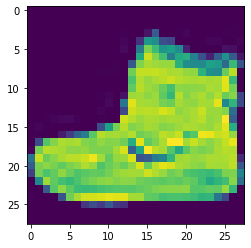

In [12]:
train, test = dsd['train'], dsd['test']
plt.imshow(train[0]['image']);
labels.int2str(train[0]['label'])

In [30]:
x, y = 'image', 'label'
img = train[0][x]

In [57]:
x,y = 'image', 'label'

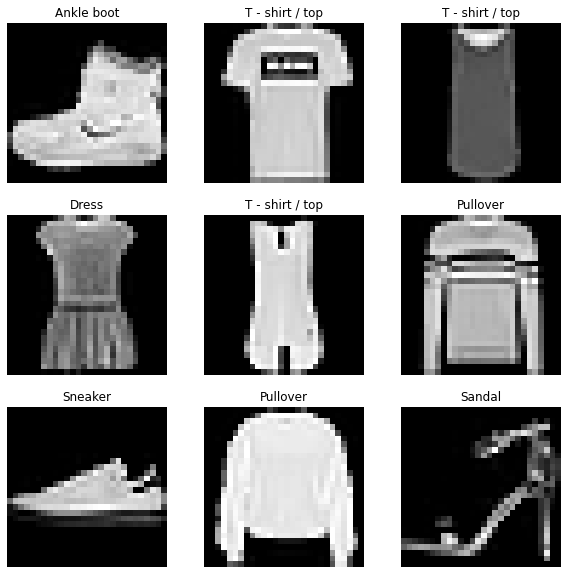

In [15]:
nrows=3
ncols=3

fig, axs = plt.subplots(nrows, ncols, figsize=(10, 10))
with plt.style.context('grayscale'):
    for i in range(nrows):
        for j in range(ncols):
            e = train[3*i + j]
            axs[i,j].imshow(e['image'])
            axs[i,j].set_title(labels.int2str(e['label']))
            axs[i,j].set_axis_off()  

In [16]:
def collate_fn(b):
    return {x: torch.stack([TF.to_tensor(o[x]) for o in b]),
           y: tensor([o[y] for o in b])}

In [17]:
dl = DataLoader(train, collate_fn=collate_fn, batch_size=32)
b = next(iter(dl))
b[x].shape, b[y]

(torch.Size([32, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8, 4, 3, 0, 2, 4, 4, 5, 3]))

In [18]:
def transforms(b):
    b[x] = [TF.to_tensor(o) for o in b[x]]
    return b

In [19]:
tds = train.with_transform(transforms)

In [20]:
dl = DataLoader(tds, batch_size=32)
b = next(iter(dl))
b[x].shape, b[y]

(torch.Size([32, 1, 28, 28]),
 tensor([9, 0, 0, 3, 0, 2, 7, 2, 5, 5, 0, 9, 5, 5, 7, 9, 1, 0, 6, 4, 3, 1, 4, 8, 4, 3, 0, 2, 4, 4, 5, 3]))

In [21]:
#| export

def inplace(f):
    def _f(b):
        f(b)
        return b
    return _f

In [32]:
@inplace
def transformi(b): 
    """The decorator takes care of returning the input which contains the mutated result"""
    b[x] = [torch.flatten(TF.to_tensor(o)) for o in b[x]]

In [33]:
tdsf = train.with_transform(transformi)

In [34]:
r = tdsf[0]
r[x].shape, r[y]

(torch.Size([784]), 9)

In [35]:
#|export
def collate_dict(ds):
    get = itemgetter(*ds.features)
    def _fb(b): return get(default_collate(b))
    return _fb

In [128]:
dlf = DataLoader(tdsf, batch_size=64, collate_fn=collate_dict(tdsf))
xb, yb = next(iter(dlf))
xb.shape, yb.shape

(torch.Size([64, 784]), torch.Size([64]))

# Plotting images

In [129]:
from IPython.core.debugger import set_trace

In [130]:
#|export
@fc.delegates(plt.Axes.imshow)
def show_image(im, ax=None, figsize=None, title=None, noframe=True, **kwargs):
    "Shows a PIL or Pytorch image on ax"
    if fc.hasattrs(im, ('cpu', 'permute', 'detach')):
        im = im.detach().cpu() # Move the image off the accelerator
        if len(im.shape) == 3 and im.shape[0] < 5: im = im.permute(1, 2, 0)
    elif not isinstance(im, np.ndarray): im=np.array(im)
    if im.shape[-1] == 1: im=im[...,0]
    if ax is None: _, ax = plt.subplots(figsize=figsize)
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.set_xticks([])
    ax.set_yticks([])
    if noframe: ax.axis('off')
    return ax

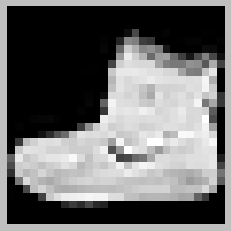

In [136]:
b = next(iter(dl))
xb = b['image']
img = xb[0]

with plt.style.context('grayscale'):
    show_image(img);

In [137]:
#|export
@fc.delegates(plt.subplots, keep=True)
def subplots(
    nrows: int=1, 
    ncols: int=1, 
    figsize:tuple=None, 
    imsize:int=3, 
    subtitle:str=None,
    **kwargs):
    """A figure and set of subplots to display images of `imsize` inches"""
    if figsize is None: figsize=(ncols*imsize, nrows*imsize)
    fig, ax = plt.subplots(nrows, ncols, figsize=figsize, **kwargs)
    if subtitle is not None: fig.subtitle(subtitle)
    if nrows*ncols==1: ax = np.array([ax])
    return fig, ax

In [138]:
from nbdev.showdoc import show_doc

In [139]:
show_doc(subplots)

---

### subplots

>      subplots (nrows:int=1, ncols:int=1, figsize:tuple=None, imsize:int=3,
>                subtitle:str=None, sharex=False, sharey=False, squeeze=True,
>                subplot_kw=None, gridspec_kw=None, **kwargs)

A figure and set of subplots to display images of `imsize` inches

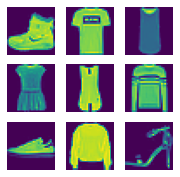

In [141]:
fig, axs = subplots(3,3, imsize=1)
imgs = xb[:9]
for ax, img in zip(axs.flat, imgs): show_image(img, ax)

In [ ]:
#|export
@fc.delegates(subplots)
def get_grid(
    n:int,
    nrows:int=None,
    ncols:int=None,
    title:str=None,
    weight:str='bold',
    size:int=14,
    **kwargs):
    """Return a grid of `n` axes, `rows`, by `cols`"""
    if nrows: ncols = ncols or int(np.floor(n/nrows))
    elif ncols: nrows = nrows or int(np.ceil(n/ncols))
    else:
        nrows = int(math.sqrt(n))
        ncols = int(np.ceil(n/nrows))
    fig, axs = subplots(nrows, ncols, **kwargs)
    for i in range(n, nrows*ncols): axs.flat[i].set_axis_off()
    if title is not None: fig.suptitle(title, weight=weight, size=size)
    return fig, axs

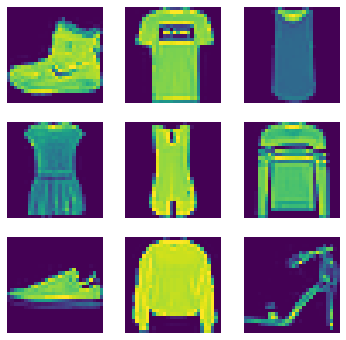

In [148]:
fig, axs = get_grid(10, nrows=3, imsize=2)
for ax, img in zip(axs.flat, imgs): show_image(img, ax)

In [157]:
#|export
@fc.delegates(subplots)
def show_images(ims:list,
                nrows:int|None=None,
                ncols:int|None=None,
                titles:list|None=None,
                **kwargs):
    "Show all images `ims` as subplots with `rows` using `titles`"
    axs = get_grid(len(ims), nrows, ncols, **kwargs)[1].flat
    for im, t, ax in zip_longest(ims, titles or [], axs): show_image(im, ax=ax, title=t)


In [166]:
yb = b[y]
imgs = xb[:8]
lbls = yb[:8]

In [167]:
names = "Top Trouser Pullover Dress Coat Sandal Shirt Sneaker Bag Boot".split()
titles = itemgetter(*lbls)(names)
' '.join(titles)

'Boot Top Top Dress Top Pullover Sneaker Pullover'

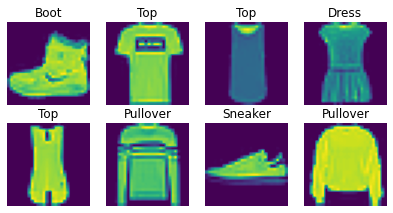

In [168]:
show_images(imgs, nrows=2, imsize=1.7, titles=titles)

In [1]:
#|export
def get_dls(train_ds, valid_ds, bs, **kwargs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
        DataLoader(valid_ds, batch_size=bs*2, **kwargs))

class DataLoaders:
    def __init__(self, *dls): self.train,self.valid = dls[:2]

    @classmethod
    def from_dd(cls, dd, bs, as_tuple=True, **kwargs):
        f = collate_dict(dd['train'])
        train_dl, valid_dl, *_ = dd.values()
        args = get_dls(train_dl, valid_dl, bs=bs, collate_fn=f, **kwargs)
        return cls(*args)

# Export

In [2]:
import nbdev; nbdev.nbdev_export()